# LVM Data Simulator tutorial: 2D simulations


**This is a tutorial on how run the simulator to produce 2D Raw spectra in the same format as they will be obtained with LVM. This is developed mainly for DRP tests.**
- How to install the simulator and how to prepare a custom simulation is shown in [tutorial #1](https://github.com/sdss/lvmdatasimulator/blob/main/examples/LVM_data_simulator_tutorial1.ipynb)
- More details on the setup of LVM instrumentation and on the structure of the outputs of the simulator are given in [tutorial #2](https://github.com/sdss/lvmdatasimulator/blob/main/examples/LVM_data_simulator_tutorial2.ipynb)
- More realistic and useful simulations are considered in [tutorial #3](https://github.com/sdss/lvmdatasimulator/blob/main/examples/LVM_data_simulator_tutorial3.ipynb) - please go there if you have already installed and configured the package and want to learn how to simulate the source field in more details.
- If you want to learn how to use the code as exposure time calculator (ETC) - please go there [tutorial #4](https://github.com/sdss/lvmdatasimulator/blob/main/examples/LVM_data_simulator_tutorial4.ipynb).

_Last update: 2023/02/27_


Producing of 2D Raw LVM spectra is very similar to 1D case, but you need to use the `Simulator2D` class instead of the `Simulator`. Modelling of the source field, initialization of the instrument (telescope + spectrograph) properties and of the observational conditions are performed in the the same was as for 1D case (see tutorials 1--3 for details).

In [1]:
from lvmdatasimulator.simulator2d import Simulator2D
from lvmdatasimulator.field import LVMField
from lvmdatasimulator.observation import Observation
from lvmdatasimulator.telescope import LVM160
from lvmdatasimulator.instrument import LVMSpectrograph
from lvmdatasimulator.fibers import FiberBundle

import astropy.units as u
from matplotlib import pyplot as plt
import os

Go to the directory where the results will be saved

In [2]:
os.chdir("/Users/mors/Science/LVM/Sim2D/")

Below we initialize the properties of the telescope, spectrograph, fiber bundles, observational conditions, source field. We skip the details here (see tutorials 1-3).
We will create relatively complex source field containing DIG and two expanding bubbles. We are going to simulate the spectra for the entire fiber bundle.
__N.B.: The simulation below takes 40-60 minutes. To decrease this time, you can simplify the source field (e.g., exclude the bubbles) or/and limit the number of rings in the `FiberBundle`.__

In [3]:
tel = LVM160()
spec = LVMSpectrograph()

bundle = FiberBundle(bundle_name='full')  # add nrings=XX in order to limit the simulations by XX rings only

ra = 12.34 # u.degree
dec = -20.35 # u.degree
fov_size = 35 # u.arcmin
fov_pixel = 5 # u.arcsec
distance = 50 # * u.kpc
turbulent_sigma = 20 #* u.km / u.s

exptimes = [900] # in seconds
obs = Observation(ra=ra, dec=dec, unit_ra=u.deg, unit_dec=u.deg, exptimes=exptimes)

[INFO]: Using the full hexagon pattern


In [4]:
name = 'LVM_2D_full'
my_lvmfield = LVMField(ra=ra, dec=dec, size=fov_size, pxsize=fov_pixel, name=name,
                       ism_params={'distance': distance, 'turbulent_sigma': turbulent_sigma, 'vel_amplitude': 250})
my_lvmfield.generate_gaia_stars(gmag_limit=15)
dig = {"type": 'DIG', 'max_brightness': 5e-16, 'perturb_amplitude': 0.2, 'perturb_scale': 500 * u.pc}
bubble1 = {'type': 'Bubble', 'max_brightness': 2e-14, 'radius': 40, 'expansion_velocity':50, 'thickness':0.2, 'sys_velocity': 40,
          'model_params': {'Z': 0.8, 'qH': 51., 'nH': 10}, 'model_type': 'cloudy', 'offset_X': 0, 'offset_Y':-40}
bubble2 = {'type': 'Bubble', 'max_brightness': 1e-15, 'radius': 70, 'expansion_velocity':25, 'thickness':0.3, 'sys_velocity': -30,
          'model_params': {'Z': 0.8, 'qH': 50., 'nH': 10}, 'model_type': 'cloudy', 'offset_X': -40, 'offset_Y':90}

my_lvmfield.add_nebulae([dig, bubble1, bubble2])

[INFO]: 719 Gaia stars in the field
[INFO]: 685 stars are fainter than 15 and have been rejected
[INFO]: Transforming world coordinates to pixel coordinates
[INFO]: Associating spectra to stars using library pollux_resampled_v0.fits...


INFO: Query finished. [astroquery.utils.tap.core]


[INFO]: Rescaling 34 synthetic spectra.


[INFO]: Saving star list to: ./LVM_2D_full/LVM_2D_full_starlist.fits.gz
[WARNING]: The file ././LVM_2D_full/LVM_2D_full_starlist.fits.gz already exist and it will be overwritten
[INFO]: Start generating 3 nebulae
[WARNING]: No model ids or model parameters are set for the nebula #0: use default cloudy 'model_id=Cloud_227'. Its parameters: Geometry = Cloud; Z = 0.8; nH = 100.0; Teff = 40000.0; LogLsun = 6.0; 
[WARNING]: Use the closest pre-computed model with id = Cloud_289. Its parameters: Geometry = Cloud; Z = 0.8; qH = 51.0; LogLsun = 7.5; Teff = 30000.0; nH = 30.0; 
[WARNING]: Use the closest pre-computed model with id = Cloud_956. Its parameters: Geometry = Cloud; Z = 0.8; qH = 50.0; LogLsun = 6.5; Teff = 30000.0; nH = 30.0; 


[WARNING]: Bundle center coords are not defined, using the coords of the field.


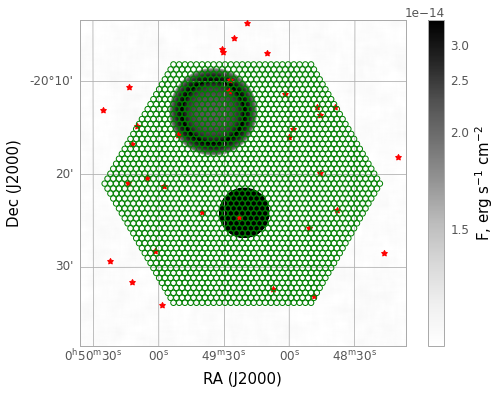

In [5]:
my_lvmfield.show(cmap=plt.cm.Greys, percentile=96, fibers=bundle.fibers_science)

We created the source field and initialized all other required objects. Now we put everything into 2D simulator defined by the class `Simulator2D`. Its initialization is the same as for `Simulator` in 1D case, but the available methods are different

In [6]:
sim = Simulator2D(my_lvmfield, obs, spec, bundle, tel)

Now we create the 2D Raw spectra for all fibers in the FOV. The input spectra will be convolved with the instrumental LSF and PSF specified for all 3 channels and cameras and varying with the position on CCD and the wavelength. This is computationally expensive and takes ~10-15 min to produce initial specta and ~45-60 min to complete reprojection onto CCD (~5-7 min per channel per camera)

In [7]:
sim.simulate_science()

[INFO]: Recovering target spectra for 1801 fibers.
[INFO]: Start extracting nebular spectra
[INFO]: Reading the atmospheric extinction from file.
[INFO]: Simulating the sky emission 2 days from new moon.
[INFO]: Using sky file: /Users/mors/Science/PyWorkspace/lvmdatasimulator/data/sky/LVM_LVM160_SKY_2.dat
[INFO]: Resample sky emission to instrument wavelength solution.
[INFO]: Generating standard stars
[INFO]: Standard star 1 with Teff 7500, Gmag 7.40 added.
[INFO]: Standard star 2 with Teff 7500, Gmag 6.50 added.
[INFO]: Standard star 3 with Teff 7000, Gmag 6.00 added.
[INFO]: Standard star 4 with Teff 8000, Gmag 8.80 added.
[INFO]: Standard star 5 with Teff 7750, Gmag 7.20 added.
[INFO]: Standard star 6 with Teff 8000, Gmag 5.60 added.
[INFO]: Standard star 7 with Teff 7500, Gmag 8.40 added.
[INFO]: Standard star 8 with Teff 7250, Gmag 5.40 added.
[INFO]: Standard star 9 with Teff 7250, Gmag 5.60 added.
[INFO]: Standard star 10 with Teff 8000, Gmag 7.50 added.
[INFO]: Standard star 1


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outs

[INFO]: Rescaling 24 synthetic spectra.


[INFO]: Saving science exposures with 900s exposures and 10s of exposure for each standard star
[INFO]: Project the spectra of camera #1 and blue channel onto CCD
100%|██████████| 646/646 [11:01<00:00,  1.02s/it]
[INFO]: Done for camera #1 and blue branch
[INFO]: Project the spectra of camera #2 and blue channel onto CCD
100%|██████████| 647/647 [09:58<00:00,  1.08it/s]
[INFO]: Done for camera #2 and blue branch
[INFO]: Project the spectra of camera #3 and blue channel onto CCD
100%|██████████| 643/643 [05:56<00:00,  1.81it/s]
[INFO]: Done for camera #3 and blue branch
[INFO]: Project the spectra of camera #1 and red channel onto CCD
100%|██████████| 646/646 [05:57<00:00,  1.81it/s]
[INFO]: Done for camera #1 and red branch
[INFO]: Project the spectra of camera #2 and red channel onto CCD
100%|██████████| 647/647 [06:15<00:00,  1.72it/s]
[INFO]: Done for camera #2 and red branch
[INFO]: Project the spectra of camera #3 and red channel onto CCD
100%|██████████| 643/643 [06:17<00:00,  1.

The output files saved in the `outputs` folder under the current directory (subject to change in the future release to the `output2D` under the directory defined by name of your LVM field). Names of the files follow the convention of LVM and should be recognized by DRP (e.g. `sdR-b3-00000001.fits.gz` means science (+sky+standard) spectra from camera 3, blue channel; `sdR-b3-00001001.fits.gz` -- same for flats; `sdR-b3-000010001.fits.gz` -- same for arcs; `sdR-b3-0000101.fits.gz` -- same for bias). Fits headers are simplified and their consistency with DRP still needs to be tested.
__Note: new simulations overwrite content of the `outputs` folder!__

Let's now open one of the produced files and check its content

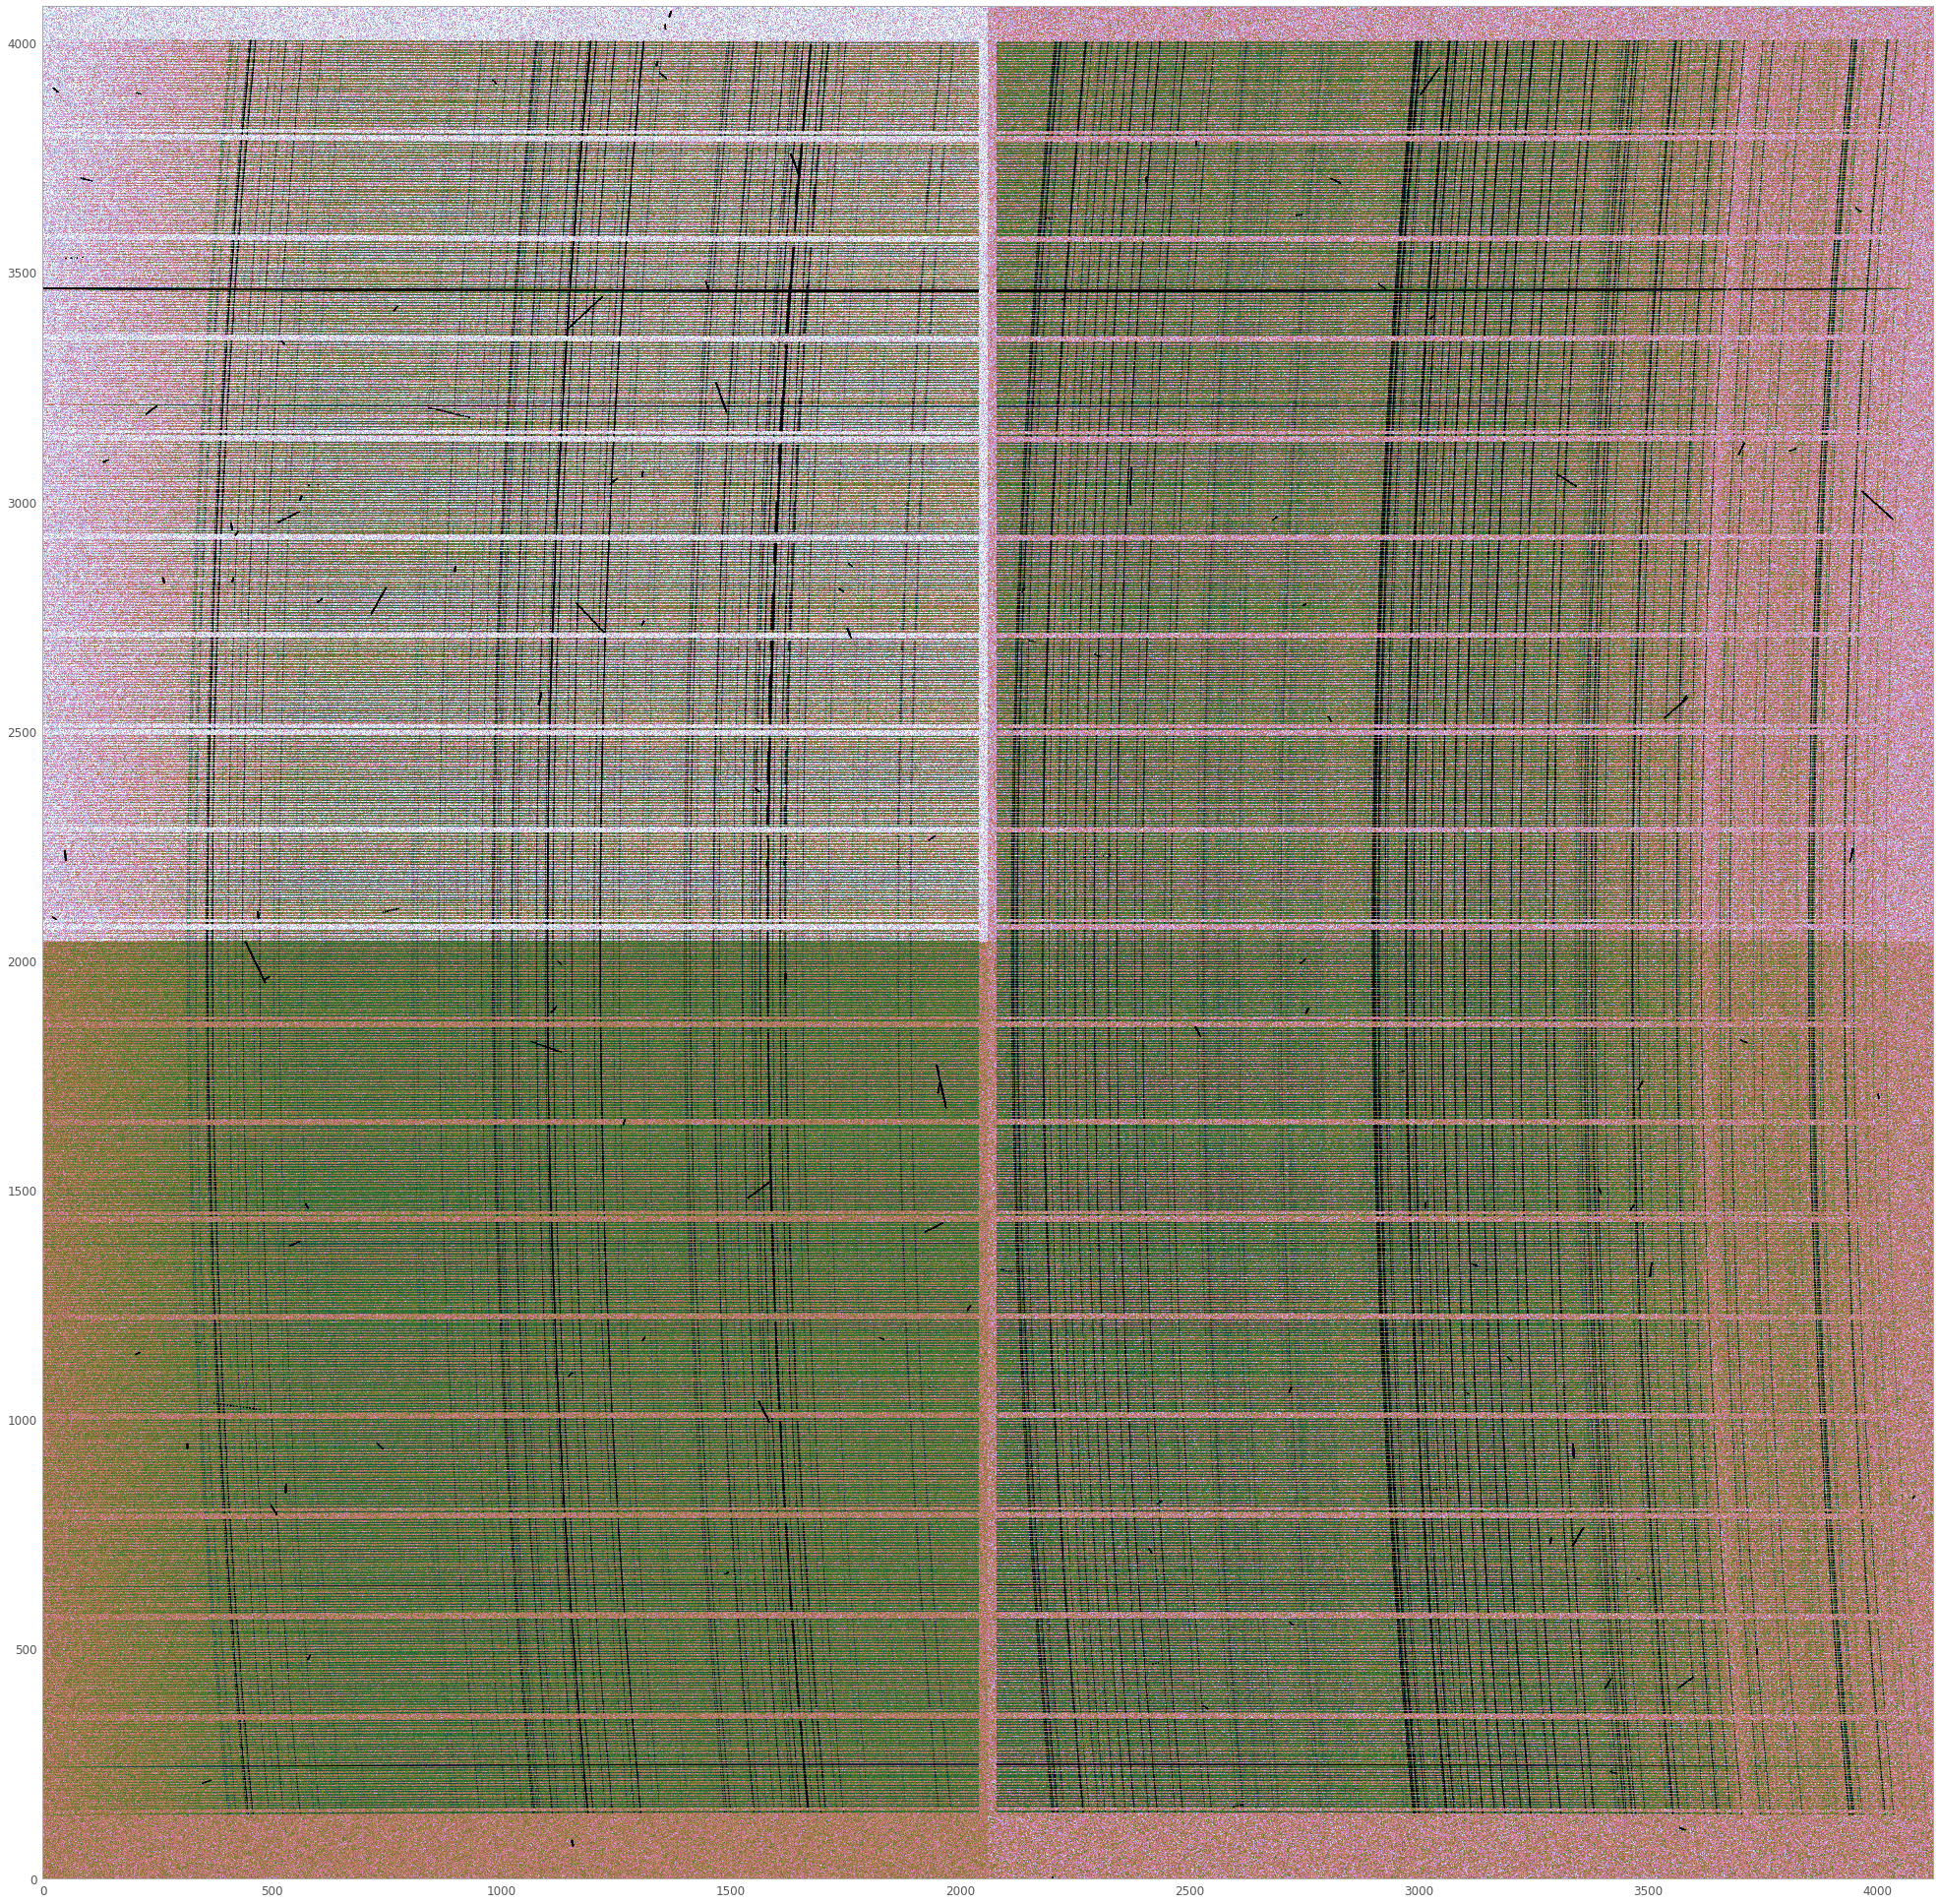

In [24]:
from astropy.io import fits
from matplotlib import pyplot as plt
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch
with fits.open("outputs/sdR-r1-00000001.fits.gz") as hdu:
    data = hdu[0].data
norm = ImageNormalize(data, interval=PercentileInterval(96), stretch=AsinhStretch())
plt.figure(figsize=(35,35))
plt.grid(False)
plt.imshow(data, norm=norm, origin='lower', interpolation='nearest', cmap=plt.cm.cubehelix_r)

The parameters of CCD defined in `data/instrument/ccd_properties.dat`. CCD consists of 4 quadrants with different bias levels, gains, readout noises. The borders between them defined in pixel coordinates as `x0`, `x1`, `x2`, `x3` and `y0`, `y1`, `y2`, `y3`. The numbers of each quadrant defined as: 1=bottom-left, 2=bottom-right, 3=top-left, 4=top-right.
Curvature of the lines and traces is parameterized in the lvmdatasimulator config file (lvmdatasimulator.yml by default)

We can zoom-in some emission lines to see how well different kinematical components are visible in the spectra

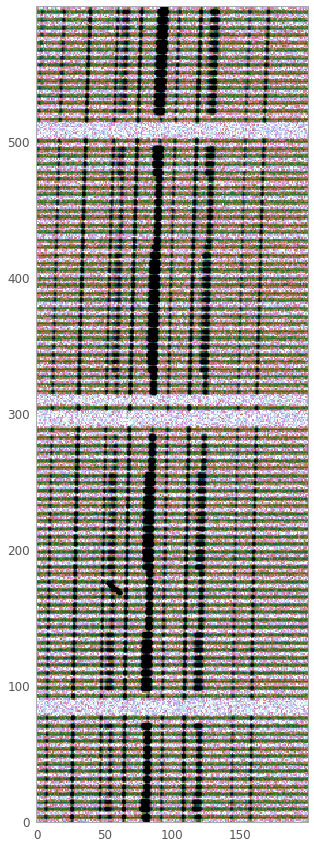

In [28]:
plt.figure(figsize=(15,15))
plt.grid(False)
plt.imshow(data[2200:2800, 1500:1700], norm=norm, interpolation='nearest',origin='lower', cmap=plt.cm.cubehelix_r)

We can also create 2D output for all the calibrations that we need (flat, arcs, bias)

In [8]:
sim.create_flat()

[INFO]: Creating flat fields...
[INFO]: Saving flat exposures with exptime 10s
[INFO]: Project the spectra of camera #1 and blue channel onto CCD
100%|██████████| 646/646 [06:49<00:00,  1.58it/s]
[INFO]: Done for camera #1 and blue branch
[INFO]: Project the spectra of camera #2 and blue channel onto CCD
100%|██████████| 647/647 [06:24<00:00,  1.68it/s]
[INFO]: Done for camera #2 and blue branch
[INFO]: Project the spectra of camera #3 and blue channel onto CCD
100%|██████████| 643/643 [06:19<00:00,  1.69it/s]
[INFO]: Done for camera #3 and blue branch
[INFO]: Project the spectra of camera #1 and red channel onto CCD
100%|██████████| 646/646 [04:40<00:00,  2.30it/s]
[INFO]: Done for camera #1 and red branch
[INFO]: Project the spectra of camera #2 and red channel onto CCD
100%|██████████| 647/647 [04:27<00:00,  2.42it/s]
[INFO]: Done for camera #2 and red branch
[INFO]: Project the spectra of camera #3 and red channel onto CCD
100%|██████████| 643/643 [04:29<00:00,  2.38it/s]
[INFO]: D

For arcs, you have to choose the "enabled" lamps

In [9]:
sim.create_arc(hg=True, ne=True, ar=True, xe=True)

[INFO]: Including Hg lamp...
[INFO]: Including Ne lamp...
[INFO]: Including Ar lamp...
[INFO]: Including Xe lamp...
[INFO]: Saving arc exposures with exptime 10s
[INFO]: Project the spectra of camera #1 and blue channel onto CCD
100%|██████████| 646/646 [04:24<00:00,  2.44it/s]
[INFO]: Done for camera #1 and blue branch
[INFO]: Project the spectra of camera #2 and blue channel onto CCD
100%|██████████| 647/647 [04:23<00:00,  2.45it/s]
[INFO]: Done for camera #2 and blue branch
[INFO]: Project the spectra of camera #3 and blue channel onto CCD
100%|██████████| 643/643 [04:22<00:00,  2.45it/s]
[INFO]: Done for camera #3 and blue branch
[INFO]: Project the spectra of camera #1 and red channel onto CCD
100%|██████████| 646/646 [04:20<00:00,  2.48it/s]
[INFO]: Done for camera #1 and red branch
[INFO]: Project the spectra of camera #2 and red channel onto CCD
100%|██████████| 647/647 [04:22<00:00,  2.47it/s]
[INFO]: Done for camera #2 and red branch
[INFO]: Project the spectra of camera #3 a

In [10]:
sim.create_bias()

[INFO]: Saving bias exposures with exptime 0s
[INFO]: Done for camera #1 and blue branch
[INFO]: Done for camera #2 and blue branch
[INFO]: Done for camera #3 and blue branch
[INFO]: Done for camera #1 and red branch
[INFO]: Done for camera #2 and red branch
[INFO]: Done for camera #3 and red branch
[INFO]: Done for camera #1 and ir branch
[INFO]: Done for camera #2 and ir branch
[INFO]: Done for camera #3 and ir branch
[INFO]: Saving bias exposures with exptime 0s
[INFO]: Done for camera #1 and blue branch
[INFO]: Done for camera #2 and blue branch
[INFO]: Done for camera #3 and blue branch
[INFO]: Done for camera #1 and red branch
[INFO]: Done for camera #2 and red branch
[INFO]: Done for camera #3 and red branch
[INFO]: Done for camera #1 and ir branch
[INFO]: Done for camera #2 and ir branch
[INFO]: Done for camera #3 and ir branch
[INFO]: Saving bias exposures with exptime 0s
[INFO]: Done for camera #1 and blue branch
[INFO]: Done for camera #2 and blue branch
[INFO]: Done for cam

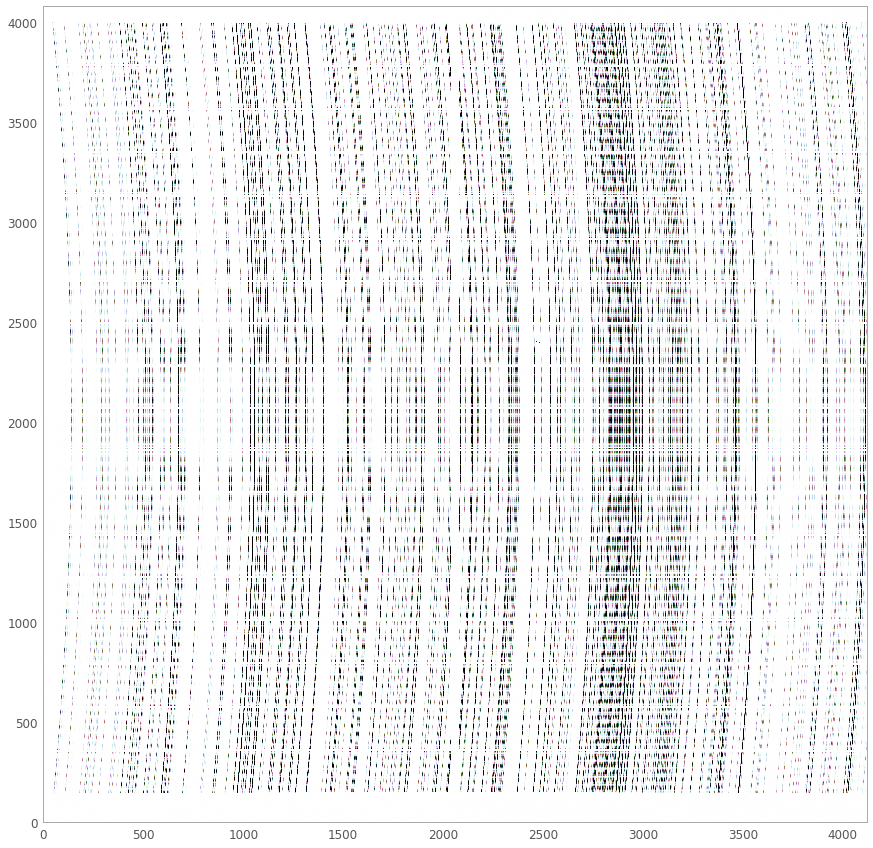

In [33]:
# Arcs in blue channel, camera 1
with fits.open("outputs/sdR-b1-00010001.fits.gz") as hdu:
    data = hdu[0].data
norm = ImageNormalize(data, interval=PercentileInterval(96), stretch=AsinhStretch())
plt.figure(figsize=(15,15))
plt.grid(False)
plt.imshow(data, norm=norm, origin='lower', interpolation='nearest', cmap=plt.cm.cubehelix_r)